# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
import sys

In [2]:
sys.path

['/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python36.zip',
 '/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6',
 '/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/lib-dynload',
 '',
 '/home/jbanjac/.local/lib/python3.6/site-packages',
 '/home/jbanjac/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages',
 '/home/jbanjac/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/jbanjac/.ipython']

In [3]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [4]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [5]:
tf.__version__

'2.2.0'

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7544638993727990072
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 493239502319764118
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5299330382518208981
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12261009856784364612
physical_device_desc: "device: XLA_GPU device"
]


In [7]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
training_description = f"unlimited_training"

In [8]:
# location of *.h5 files
#data_dir = f"{ROOT_DIR}/data"
path_logs_training = "/mnt/scratch/students"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(path_logs_training, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [9]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [10]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [11]:
# plot_angles_count(angles_true)

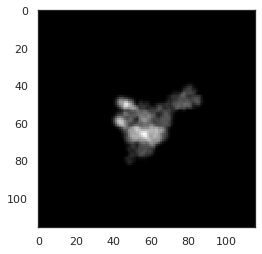

In [12]:
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

---

## Prepare for training

In [13]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [14]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [15]:
from cryoem.distance_estimation import global_standardization

In [16]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [17]:
test_size = 0.33
val_size = 0.25

In [18]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [19]:
data = np.load(f"/mnt/scratch/students/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [20]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [21]:
X.shape

(5000, 116, 116, 1)

# 1. Distance Estimation

### Train the model

In [22]:
# UNIFORM
from tensorflow.keras.utils import Sequence
from time import time
num_dec = 1
num_bins = 32

# # for weights
# dQ_values = np.load("data/5j0n/dQ_values_100K.npy")
# distribution = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
# probabilities = distribution[0]
# weights = 1/probabilities
# weights_norm = weights/sum(weights)

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
                bins[np.around(label, num_dec)].append([idx1, idx2])

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)

        #weights = np.array(self._get_weights(labels))
        #labels_and_weights = np.stack((labels, weights), axis=1)
        
        # [training_pairs[:, 0], training_pairs[:, 1]], labels
        return [pairs[:, 0], pairs[:, 1]], labels 
        
    #def _get_weights(self, labels):
    #    l = labels.numpy()
    #    return np.array(list(map(lambda x: probabilities[np.where(x >= distribution[1])[0][-1]], l)))    
    
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [23]:
#import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.rotation_matrices import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, TensorBoard, LambdaCallback, EarlyStopping
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE
import pandas as pd
import seaborn as sns
import io

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None

CALLBACK_FREQ = 100

def cosine_distance(vests):
    x, y = vests
    xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
    xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
    xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
    yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
    yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
    cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
    eps = K.epsilon()
    return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    #x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
    #x = tf.squeeze(x, axis=[1,2])
    x = Flatten()(x)
    x = Dense(4)(x)

    return Model(input_x, x)


def train_siamese(X, y, train_idx, val_idx, epochs, batch_size, learning_rate, limit_style, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        
        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style=limit_style, shuffle=True)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=limit_style, shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

        global model
       

        # train
        if gpus:
            m = Model([input_a, input_b], distance)  # was m
            model = multi_gpu_model(m, gpus=gpus)
        else:
            model = Model([input_a, input_b], distance)  # was m
            
        model.summary()
        #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

        # Setup callbacks
        # Callback that saves the model
        training_description = training_description or strftime('%Y%m%d_%H%M%S')
        CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
        pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
        backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=CALLBACK_FREQ)
        print(f"Model will be saved to: {CHECKPOINT_PATH}")
        
        # Callback that will show tensorboard data
        LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1, update_freq=CALLBACK_FREQ) #, profile_batch=300)#100000000)
        
        # Callback for the dP/dQ plot
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))
        # Callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)
        # Callback to stop training
        stop_callback = EarlyStopping(monitor="val_loss")#, patience=20)


        history1 = model.fit(training_generator, 
                            epochs=epochs,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback, backup_callback, stop_callback])
        
        # Get training and test loss histories
        training_loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        mses = history1.history['mse']
        val_mses = history1.history['val_mse']
        pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
        np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, mses, val_mses)

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        return model, history1

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [24]:
# import os
# import h5py
# from time import time, strftime
# from datetime import datetime
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.model_selection import train_test_split
# import pathlib

# from cryoem.rotation_matrices import RotationMatrix
# from cryoem.conversions import euler2quaternion, d_q
# from cryoem.knn import get_knn_projections

# import random
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.models import Model
# from tensorflow.python.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
# from tensorflow.keras.optimizers import RMSprop, Adam, SGD
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, TensorBoard, LambdaCallback, EarlyStopping
# from tensorflow.keras.utils import plot_model, multi_gpu_model
# #from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.losses import KLD, MAE, MSE
# import pandas as pd

# _idx1 = list(np.random.choice(val_idx, size=1000))
# _idx2 = list(np.random.choice(val_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in _idx1])
# q2_true = euler2quaternion([angles_true[i] for i in _idx2])

# p1 = [X[i] for i in _idx1]
# p2 = [X[i] for i in _idx2]

# model = None

# CALLBACK_FREQ = 100

# def cosine_distance(vests):
#     x, y = vests
#     xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
#     xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
#     xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
#     yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
#     yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
#     cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
#     eps = K.epsilon()
#     return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

# def cos_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)


# def mae(y_true, y_pred):
#     return MAE(y_true, y_pred) 

# def mse(y_true, y_pred):
#     return MSE(y_true, y_pred) 


# def create_siamese_network(input_shape):
#     '''Base network to be shared (eq. to feature extraction).
#     '''
#     input_x = Input(shape=input_shape)
#     #print(input_shape)

#     # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
#     x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)

#     x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
#     x = MaxPooling2D([2, 2], padding='same')(x)
    
#     #x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
#     #x = tf.squeeze(x, axis=[1,2])
#     x = Flatten()(x)
#     x = Dense(4)(x)

#     return Model(input_x, x)


# def train_siamese(X, y, train_idx, val_idx, epochs, batch_size, learning_rate, limit_style, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
#     def d_p(p1, p2):
#         global model
#         p1 = tf.cast(p1, dtype=tf.float32)
#         p2 = tf.cast(p2, dtype=tf.float32)
#         return model.predict([p1, p2], batch_size=256)

#     def plot_to_image(figure):
#         """Converts the matplotlib plot specified by 'figure' to a PNG image and
#         returns it. The supplied figure is closed and inaccessible after this call."""
#         # Save the plot to a PNG in memory.
#         buf = io.BytesIO()
#         plt.savefig(buf, format='png')
#         # Closing the figure prevents it from being displayed directly inside
#         # the notebook.
#         plt.close(figure)
#         buf.seek(0)
#         # Convert PNG buffer to TF image
#         image = tf.image.decode_png(buf.getvalue(), channels=4)
#         # Add the batch dimension
#         image = tf.expand_dims(image, 0)
#         return image

#     def generate_dPdQ_plot(file_writer_plot):
#         """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        
#         def _inner_plot(epoch, logs):
#             """Generate dP/dQ plot for tensorboard"""
#             dP_values = d_p(p1, p2).T[0]
#             dQ_values = d_q(q1_true, q2_true).numpy()

#             # Creating the dataframe for SNS plot
#             data = {"d_Q" : dQ_values, "d_P" : dP_values }
#             df1 = pd.DataFrame(data=data)

#             fig, ax = plt.subplots(figsize=(6,6));
#             sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
#             x = np.arange(0, np.pi);
#             sns.regplot(x=x, y=x, color="k", ax=ax)
#             #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
#             #plt.show()
            
#             # Log the confusion matrix as an image summary.
#             with file_writer_plot.as_default():
#                 tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
#         return _inner_plot

#     mirrored_strategy = tf.distribute.MirroredStrategy()
    
#     with mirrored_strategy.scope():
#         # Prepare data generators
#         training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style=limit_style, shuffle=True)
#         validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=limit_style, shuffle=True)
        
#         input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
#         print(f"Input images shape {input_shape}")

#         # network definition
#         input_a = Input(shape=input_shape)
#         input_b = Input(shape=input_shape)
#         cnn_network = create_siamese_network(input_shape)
        
#         # because we re-use the same instance `cnn_network`,
#         # the weights of the network will be shared across the two branches
#         processed_a = cnn_network(input_a)
#         processed_b = cnn_network(input_b)

        
#         distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

#         global model
       

#         # train
#         if gpus:
#             m = Model([input_a, input_b], distance)  # was m
#             model = multi_gpu_model(m, gpus=gpus)
#         else:
#             model = Model([input_a, input_b], distance)  # was m
            
#         model.summary()
#         #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

#         # training only top layers
#         optimizer1 = RMSprop(learning_rate=learning_rate)
#         model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

#         # Setup callbacks
#         # Callback that saves the model
#         training_description = training_description or strftime('%Y%m%d_%H%M%S')
#         CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
#         pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
#         backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1, save_freq=CALLBACK_FREQ)
#         print(f"Model will be saved to: {CHECKPOINT_PATH}")
        
#         # Callback that will show tensorboard data
#         LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
#         pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
#         logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1, update_freq=CALLBACK_FREQ) #, profile_batch=300)#100000000)
        
#         # Callback for the dP/dQ plot
#         file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
#         plot_callback = LambdaCallback(on_batch_end=generate_dPdQ_plot(file_writer_plot))
#         # Callback that will decrease LR if it gets plateau in val_loss
#         #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)
#         # Callback to stop training
#         stop_callback = EarlyStopping(monitor="val_loss", patience=1)


#         history1 = model.fit(training_generator, 
#                             epochs=epochs,
#                             validation_data=validation_generator, 
#                             callbacks=[plot_callback, stop_callback, logs_callback, backup_callback])
        
#         # Get training and test loss histories
#         training_loss = history1.history['loss']
#         val_loss = history1.history['val_loss']
#         mses = history1.history['mse']
#         val_mses = history1.history['val_mse']
#         pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
#         np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, mses, val_mses)

#         if plot:
#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

#             # Create count of the number of epochs
#             epoch_count = range(1, len(training_loss) + 1)

#             # Visualize loss history
#             ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
#             ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
#             ax1.legend()
#             ax1.set_xlabel('Epoch')
#             ax1.set_ylabel('Loss')

#             ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
#             ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
#             ax2.legend()
#             ax2.set_xlabel('Epoch')
#             ax2.set_ylabel('Loss')
#             plt.show();

#         return model, history1

# def plot_results(projections, y_pred, y, strtype):
#     if projections.shape[-1] == 1:
#         projections = projections.reshape(list(projections.shape[:-2]) +[-1])

#     def _inner(i):
        
#         plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
#         ax1.imshow(projections[i, 0])
#         ax2.imshow(projections[i, 1])

#         print(f"--- {strtype} Set ---")
#         print(f"predicted: {y_pred[i][0]}")
#         print(f"true:      {y[i].numpy()}")
#         print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
#         print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
#     return _inner

In [25]:
# 0.1 -> 34 min/epoch
# 0.01 -> 3.3 min/epoch
train_percent = 1  #0.01
val_percent = 1    #0.01
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(6310144, 702244)

In [ ]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs=2,  #500
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                                limit_style="random", 
                                path_logs_training=path_logs_training, 
                                training_description=training_description,
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Data created in 4.9622180461883545 sec
Data created in 0.5349123477935791 sec
Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4)            4553988     input_1[0][0]                    
                                                                 input_2[0][0

In [ ]:
data = np.load(f"{path_logs_training}/losses/{training_description}.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [19]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
model_filename = f"{path_logs_training}/training/20200422_114231.h5"

In [20]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 116, 116, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 116, 116, 1)  0           input_3[0][0]                    
____________________________________________________________________________________________

### Some model results

In [21]:
from cryoem.distance_estimation import plot_results

In [22]:
y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [23]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 0.9932668209075928
true:      0.88523930311203
mse:       0.01166994497179985
mae:       0.10802751779556274


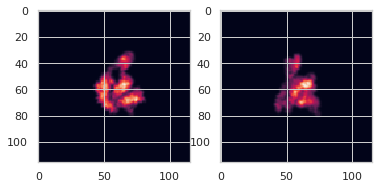

In [24]:
plot_train_results(1)

--- Validation Set ---
predicted: 1.0892571210861206
true:      1.476218581199646
mse:       0.14973917603492737
mae:       0.3869614601135254


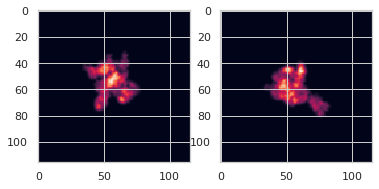

In [25]:
plot_validation_results(0)

---

## dP/dQ plot

In [26]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [27]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float64)
    p2 = tf.cast(p2, dtype=tf.float64)

    for i in np.arange(0, len(p1), 256):
        _p1 = p1[i:i+256, :, :]
        _p2 = p2[i:i+256, :, :]
        
        _p1 = tf.convert_to_tensor(_p1)
        _p1 = tf.expand_dims(_p1, len(_p1.shape)) 
        _p2 = tf.convert_to_tensor(_p2)
        _p2 = tf.expand_dims(_p2, len(_p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 

        d = model.predict_on_batch([_p1, _p2])
        d = tf.cast(d, dtype=tf.float64)
        dist.append(d)
    
    dist = tf.concat(dist, axis=0)

    return dist

In [28]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [40]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

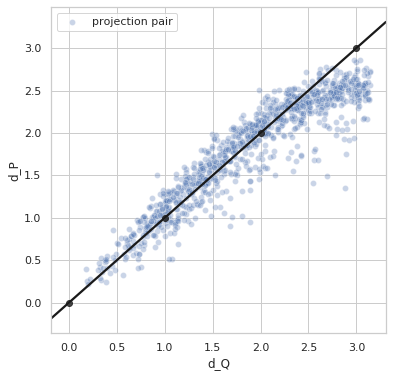

In [29]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

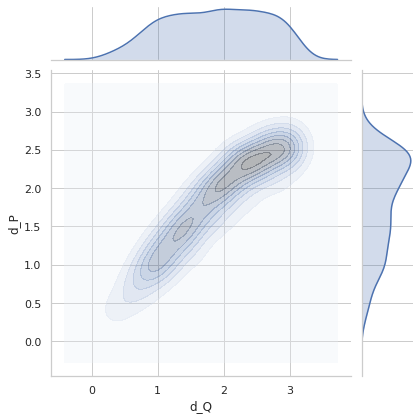

In [30]:
plot_dP_dQ_density(dP_values, dQ_values)

In [31]:
def loss(dQ_values, dP_values):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((dQ_values - dP_values), 2))

In [32]:
loss(dQ_values, dP_values).numpy()

0.08163044774825015

In [33]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.28585338883448336

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [29]:
from cryoem.angle_recovery import train_angle_recovery, angles_transpose

In [30]:
X = tf.cast(X, dtype=tf.float64)
X = X.numpy()

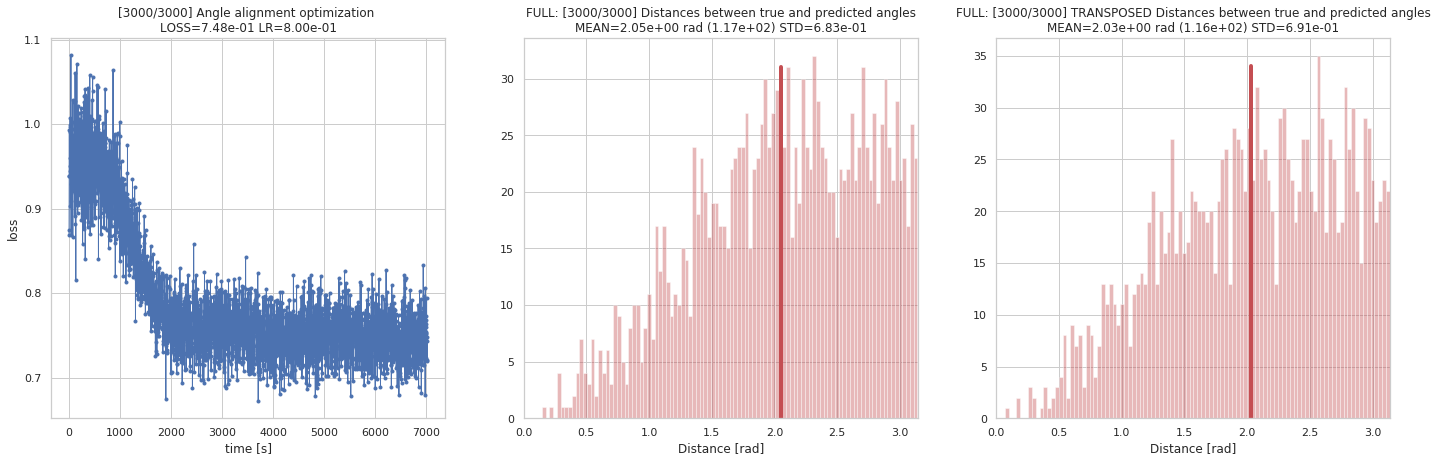

Shape of projections: (1650, 116, 116)step 300/3000 (712s): loss = 9.31e-01
step 600/3000 (1409s): loss = 8.32e-01
step 900/3000 (2108s): loss = 7.77e-01
step 1200/3000 (2807s): loss = 7.51e-01
step 1500/3000 (3507s): loss = 7.92e-01
step 1800/3000 (4207s): loss = 7.80e-01
step 2100/3000 (4908s): loss = 8.00e-01
step 2400/3000 (5610s): loss = 7.22e-01
step 2700/3000 (6312s): loss = 7.15e-01
step 3000/3000 (7015s): loss = 7.21e-01



In [33]:
q_predicted2, losses2, arr2 = train_angle_recovery(steps=3000, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.8, #0.1, 
                                                   angles_true=angles_true[test_idx],
                                                   optimization=True)

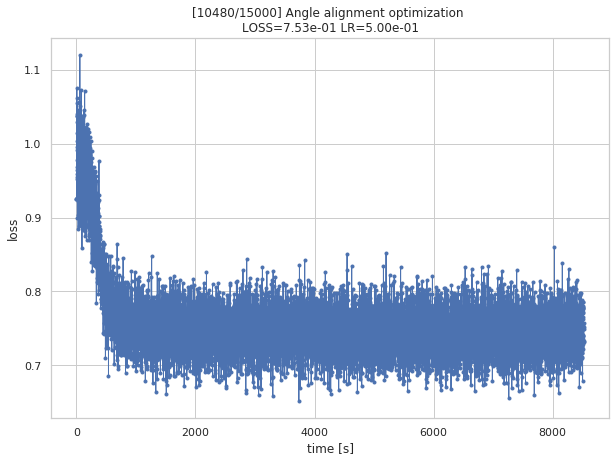

step 1500/15000 (1226s): loss = 7.61e-01
step 3000/15000 (2441s): loss = 7.71e-01
step 4500/15000 (3654s): loss = 7.33e-01
step 6000/15000 (4868s): loss = 7.34e-01
step 7500/15000 (6086s): loss = 7.21e-01
step 9000/15000 (7313s): loss = 7.46e-01



In [71]:
# train_angle_recovery(steps=300000, 
#                      batch_size=256, 
#                      projection_idx=test_idx, 
#                      angles_predicted=angles_predicted, 
#                      est_dist_input=X, 
#                      est_dist=d_p, 
#                      learning_rate=0.01, 
#                      optimization=True)
q_predicted, losses, arr = train_angle_recovery(steps=15000, 
                                  batch_size=512, 
                                 projection_idx=test_idx, 
                                 in_data=X, 
                                 distance_fn=d_p, 
                                 learning_rate=0.5, #0.1, 
                                 optimization=True)

# TODO: from quat

In [95]:
from scipy.spatial.transform import Rotation as R

arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true[test_idx]
b = arr2.copy() #arr2[:, test_idx, :]
print(b.shape)

ipv.figure()
s = ipv.scatter(b[:, :,0], b[:, :,1], b[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-np.pi, np.pi);ipv.ylim(-np.pi, np.pi);ipv.zlim(-np.pi, np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

(300, 1650, 3)


In [36]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_ar2.npy", losses2)

In [37]:
np.save("data/5j0n/predicted_quaternions_siamese_arr_ar2.npy", arr2)

In [74]:
q_save = np.zeros((len(q_predicted2),4))
for i, q in enumerate(q_predicted2):
    q_save[i] = q.numpy()
#q_save = q_save[test_idx]                 
np.save("data/5j0n/predicted_quaternions_siamese2.npy", q_save)

## Angle Alignment

In [9]:
from cryoem.conversions import quaternion2euler
import seaborn as sns; sns.set(style="white", color_codes=True)
from cryoem.plots import plot_images

In [7]:
qp = np.load("data/5j0n/predicted_quaternions_siamese2.npy")

#transposed = False
ap = quaternion2euler(qp).numpy()
#ap = angles_transpose(ap)

np.save("data/5j0n/predicted_angles_siamese2.npy", ap)

In [14]:
plot_images(ap, projections[test_idx], indices=range(100), img_size_scale=0.05)

In [77]:
qp_test = qp.copy() #qp[test_idx]
at_test = angles_true[test_idx]
ap_test = ap.copy() #ap[test_idx]

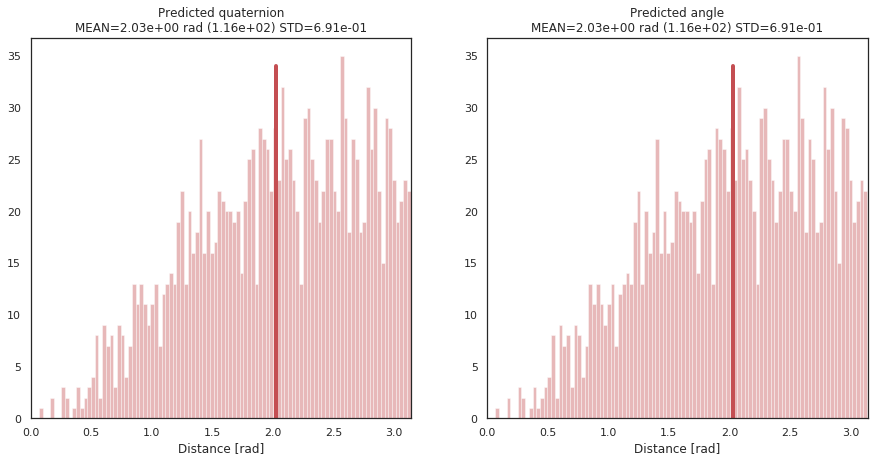

In [78]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(at_test), qp_test)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(at_test), euler2quaternion(ap_test))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

In [87]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.rotation_matrices import euler2matrix, d_r
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    with tf.device('/device:GPU:0'):
        arr = []
        
        optimizer = Adam(learning_rate=learning_rate)
        
        time_start = time.time()

        report = ""

        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(angles_predicted)

        euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
        a_R = [tf.Variable(euler)]
        
        q_predicted = euler2quaternion(angles_predicted)
        q_true = euler2quaternion(angles_true)

        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

            # Compute distances between projections
            qt = [q_true[i]      for i in idx]
            qp = [q_predicted[i] for i in idx]

            # Optimize by gradient descent.
            losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
            optimizer.apply_gradients(zip(gradients, a_R))
            
            update_lr = 300
            if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
                learning_rate *= 0.1

            # Visualize progress periodically
            if step % 10 == 0:
                qu = update_quaternion(m, a_R, q_predicted)
                
                arr.append(R.from_quat(update_quaternion(m, a_R, q_predicted)).as_rotvec())
                
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(1, 3, figsize=(24,7))
                
                # Distance count subplot (batches)
                qpr = update_quaternion(m, a_R, qp)
                d1 = d_q(qpr, qt)
                axs[0].set_xlim(0, np.pi)
                #axs[0].set_ylim(0, batch_size)
                axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
                s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # Optimization loss subplot
                axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[1].set_xlabel('time [s]')
                axs[1].set_ylabel('loss');
                axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")
                
                # Distance count subplot (full)
                q_predicted_rot = update_quaternion(m, a_R, q_predicted)
                d2 = d_q(q_predicted_rot, q_true)
                axs[2].set_xlim(0, np.pi)
                # axs[2].set_ylim(0, len(angles_true))
                axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                
                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(1.0)
        

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

            if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
                break;

        print(report)
        return m, a_R, losses, np.array(arr)

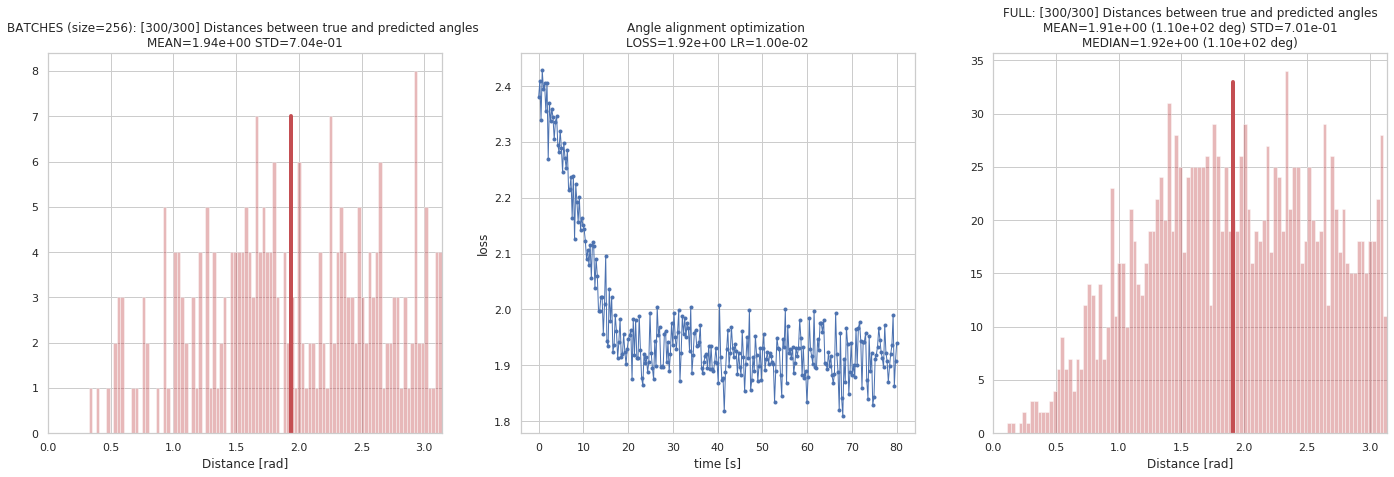

step 30/300 (8s): loss = 2.32e+00
step 60/300 (16s): loss = 2.09e+00
step 90/300 (25s): loss = 1.94e+00
step 120/300 (33s): loss = 1.93e+00
step 150/300 (41s): loss = 1.93e+00
step 180/300 (49s): loss = 1.91e+00
step 210/300 (57s): loss = 1.91e+00
step 240/300 (66s): loss = 1.93e+00
step 270/300 (74s): loss = 1.90e+00
step 300/300 (82s): loss = 1.91e+00



In [91]:
m, rotation, loss, arr_aa = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=300, 
                                             batch_size=256,  
                                             learning_rate=0.01, 
                                             angles_true=angles_true[test_idx], 
                                             angles_predicted=ap)

In [92]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([4.06229592, 3.19459292, 5.80746796, 5.93206813, 2.64329271,
        4.62564705]),
 1.9399684617821265)

In [93]:
from scipy.spatial.transform import Rotation as R

arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true[test_idx]
b = arr_aa.copy() #arr_aa[:, test_idx, :]
print(b.shape)

ipv.figure()
s = ipv.scatter(b[:, :,0], b[:, :,1], b[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

(30, 1650, 3)


In [86]:
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr_aa[:, :,0], arr_aa[:, :,1], arr_aa[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

In [71]:
qpn = euler2quaternion(ap)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted = quaternion2euler(qpa).numpy()

np.save("data/5a1a/predicted_angles_siamese_updated2.npy", angles_predicted)

In [108]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---